# Introduction & Background

Housing in Singapore has never been a cheap affair, [with CBRE ranking Singapore as the country with the 3rd highest average property price of US$915,601 in 2020](https://www.cbreresidential.com/uk/sites/uk-residential/files/CBRE-Global%20Living_2020_Final.pdf). Is that intimidating figure representative of the actual situation in Singapore? In this notebook, we investigate [HDB flats' resale prices](https://data.gov.sg/dataset/resale-flat-prices) from 2017-01-01 to 2021-01-31. For the uninitiated, HDB flats are built primarily to provide affordable public housing.

Some questions we may want to answer are:
- how stable have prices been? did the covid situation affect the housing market?
- factors affecting price? (easy to pin everything down to location. but other factors like house, upcoming plans also affect)
- are all houses equal i.e same size?
- given past data, can we reliably predict on new unseen data

# Exploratory Data Analysis

First, let's take a quick glance at our data.

In [8]:

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format # Formatting for floats

data = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

summary = data.describe(include='all')
summary

month      town flat_type  block     street_name storey_range  \
count     90123     90123     90123  90123           90123        90123   
unique       49        26         7   2484             551           17   
top     2018-07  SENGKANG    4 ROOM      2  YISHUN RING RD     04 TO 06   
freq       2539      7372     37302    307            1350        20957   
mean        NaN       NaN       NaN    NaN             NaN          NaN   
std         NaN       NaN       NaN    NaN             NaN          NaN   
min         NaN       NaN       NaN    NaN             NaN          NaN   
25%         NaN       NaN       NaN    NaN             NaN          NaN   
50%         NaN       NaN       NaN    NaN             NaN          NaN   
75%         NaN       NaN       NaN    NaN             NaN          NaN   
max         NaN       NaN       NaN    NaN             NaN          NaN   

        floor_area_sqm flat_model  lease_commence_date     remaining_lease  \
count         90123.00      90123             90123.00               90123   
unique             nan         20                  nan                 632   
top                nan    Model A                  nan  94 years 09 months   
freq               nan      29432                  nan                 713   
mean             97.76        NaN              1994.38                 NaN   
std              24.28        NaN                13.02                 NaN   
min              31.00        NaN              1966.00                 NaN   
25%              82.00        NaN              1984.00                 NaN   
50%              95.00        NaN              1995.00                 NaN   
75%             113.00        NaN              2003.00                 NaN   
max             249.00        NaN              2019.00                 NaN   

        resale_price  
count       90123.00  
unique           nan  
top              nan  
freq             nan  
mean       443746.19  
std        154381.36  
min        140000.00  
25%        332000.00  
50%        413800.00  
75%        520000.00  
max       1258000.00

`describe()` will obtain the most frequent value for categorical variables and descriptive statistics for continuous variables. 

It seems that the town with the most number of transactions is Sengkang and the most common flat type is a 4-room flat. On average, a flat is 97.76 square metres large, costs S$443,746 and is about 27 years old (calculated from `lease_commence_date` since it is a float. `remaining_lease` is in string format and is thus unreliable).

We can also go one step further and analyse several variables individually.

### Month

In [9]:
import plotly.express as px

month = data.groupby('month').agg(['count', 'mean'])
month = month[[
        ('resale_price', 'count'),
        ('resale_price', 'mean')
        ]].reset_index()
month.columns = ['Month', 'Number of transactions', 'Mean resale price in S$']

fig = px.line(
        month, 
        x="Month", 
        y="Number of transactions", 
        title='Monthly transactions',
        hover_data={
                "Mean resale price in S$":":.2f", 
                "Month": "|%b %Y"})
fig.show()

### **Note:** We will be using `plotly` figures which are *interactive*. Some things you can do:
* Hover over data points for additional information (you should be able to see the month, number of transactions and mean resale price in the figure above)
* Draw a box to zoom in on a specific area
* Double click anywhere to zoom out if you have zoomed in

In this figure, we counted the number of transactions for each month and the average price of all transactions in that month. There seem to be annual dips in January and February of each year from 2017 to 2019 which is consistent with the notion that [Chinese New Year tends to be a lull period for real estate activities](https://www.era.com.sg/more-upside-for-the-hdb-resale-market/). The huge drop in April 2020 is likely due to the [circuit breaker](https://en.wikipedia.org/wiki/2020%E2%80%9321_Singapore_circuit_breaker_measures#Initial_measures_(7_April)) implemented in response to the pandemic. 

An interesting point to note is that after the circuit breaker, the number of monthly transactions surged drastically, closely approaching the previous 3-year high of July 2018. Also, the average monthly transaction price has steadily increased since Sep 2020 which can be clearly seen in the next figure below. This increase in demand could be due to several reasons such as [low interest rates](https://www.todayonline.com/singapore/despite-recession-singapores-property-market-surprises-again-stellar-new-private-home) and [the halting of construction work for ongoing BTO flats](https://www.straitstimes.com/singapore/housing/halt-in-construction-works-leaves-home-owners-in-a-bind) which has led to [delays in owners getting their keys](https://www.straitstimes.com/singapore/housing/some-bto-flats-may-be-delayed-up-to-nine-months-up-from-previous-six-months-hdb), forcing prospective BTO buyers to resale flats instead. 


In [10]:
fig = px.line(
        month, 
        x="Month", 
        y="Mean resale price in S$", 
        title='Mean monthly resale price',
        hover_data={
                "Number of transactions":":.d", 
                "Month": "|%b %Y"})
fig.update_layout(yaxis_tickformat ='.2f') 
fig.show()

Here, it is easy to see that the mean resale price has increased significantly since September 2020 and does not show signs of stopping.

Next, we analyse the data through the perspective of towns.

### Town

In [11]:
towns = data.groupby('town').agg(['count', 'mean'])

# transactions per town 
towns_transac = towns[[('resale_price', 'count')]].reset_index()
towns_transac.columns = ['Town', 'Number of transactions']
fig = px.pie(
        towns_transac, 
        values='Number of transactions', 
        names='Town', 
        title='Distribution of towns')
fig.show()

Gentle reminder: the figures are **interactive**.

As seen in our quick summary at the beginning of the notebook, the town with the most number of transactions is indeed Sengkang. However, it does not even account for 10% of all transactions, with several other towns having a similar number of transactions namely Jurong West and Woodlands.

In [12]:
# mean price per town
towns_meanprice = towns[[('resale_price', 'mean')]].reset_index()
towns_meanprice.columns = ['Town', 'Mean resale price in S$']
towns_meanprice.sort_values(
        'Mean resale price in S$', 
        ascending=False, 
        inplace=True)
towns_meanprice = towns_meanprice.merge(towns_transac, on='Town') 
fig = px.bar(
        towns_meanprice, 
        x='Town', 
        y='Mean resale price in S$',
        title="Mean resale price by town",
        hover_data=['Number of transactions'])
fig.update_layout(yaxis_tickformat ='.2f') 
fig.show()

Calculating the mean resale price per town, we can see that there are a handful of towns with significantly higher resale prices than all other towns - Bukit Timah, Bishan, Central Area, Queenstown and Bukit Merah. This actually makes sense since these towns are located very centrally. **(see picture below??)** A minor point to note is that although Bishan may not be as close to the city centre as the other 4 towns, it does sit at the intersection of two crucial train lines which makes commuting very convenient and it is also among the top 5 towns with the largest average sizes as seen in the next figure.

It may be tempting to say that resale prices are way too high as seen in Bukit Timah, Bishan and Central Area but it is also important to note that these three towns only made up *3.066% of all transactions* in the data and are thus not a good representation of the norm.

## include pic of map? 

On the other hand, the towns with the lowest resale prices tend to be in the suburban areas. Yishun, Woodlands and Sembawang are all located in the North and travelling from those towns to the city centre takes about an hour by train. If we proceed further with this logic however, the towns of Ang Mo Kio and Bedok may raise some eyebrows since they are quite centrally located. Punggol is also situated close to an hour from the city centre and yet it sits tidily in the middle. This suggests that there may be other factors beyond physical location affecting these towns.

In [13]:
# mean sqm per town 
towns_meansqm = towns[[('floor_area_sqm', 'mean')]].reset_index()
towns_meansqm.columns = ['Town', 'Mean square metres']
towns_meansqm.sort_values(
        'Mean square metres', 
        ascending=False, 
        inplace=True)
fig = px.bar(
        towns_meansqm, 
        x='Town', 
        y='Mean square metres',
        title="Mean square metres by town")
fig.update_layout(yaxis_tickformat ='.2f') 
fig.show()

This figure calculates the average size of houses in each town. An immediate observation is that 2 of the most expensive towns (Central Area and Queenstown) as seen in the previous figure are actually the smallest on average. It is thus not unreasonable to suggest that the main factor contributing to the high prices of flats in those two towns are their physical locations.

Also, we can see that Ang Mo Kio is on the smaller end of the size spectrum which may help explain its lower price despite being a central town.

Lastly, an interesting note is that Pasir Ris may be the 7th most expensive town but it is the largest town by a *wide* margin. This may be due to the fact that Pasir Ris has lots of forested area and thus space is less of a constraint when building new units as compared to towns such as Ang Mo Kio or Bishan that are already fully developed.

In [14]:
# mean lease date per town
towns_lease = towns[[('lease_commence_date', 'mean')]].reset_index()
towns_lease.columns = ['Town', 'Mean lease commence date']
towns_lease.sort_values(
        'Mean lease commence date', 
        ascending=False, 
        inplace=True)
towns_lease = towns_lease.merge(towns_transac, on='Town') 
fig = px.bar(
        towns_lease, 
        x='Town', 
        y='Mean lease commence date',
        title="Mean lease commence date by town")
fig.update_layout(yaxis_tickformat ='.0f') 
fig.update_yaxes(range=[1970, 2015]) 
fig.show()

A larger `lease_commence_date` means the property is newer while a smaller `lease_commence_date` means the property is older. This is actually very important because as you might have inferred in the beginning about the `remaining_lease` column, [all HDB flats have a 99 year lease period](https://www.99.co/singapore/insider/99-year-hdb-lease/). When the lease expires, it is returned to the government. This means that if the property is really old i.e a small `lease_commence_date` value, then there is simply less time the owner can live in it.

This may further explain why flats in the towns of Ang Mo Kio and Bedok have lower resale prices - they are simply older.

On the other end of the spectrum, we can see that the newer towns tend to be in the surburbs - Punggol, Sengkang and Sembawang. Interestingly, there is an offical term to describe these towns: [non-mature estates](https://dollarsandsense.sg/non-mature-vs-mature-hdb-estates/). Sengkang flats beat Punggol flats in terms of size and location. Yet, they are still slightly cheaper. How is that the case? The difference of 4 years in `lease_commence_date` could be a factor but I believe there is an even stronger one not seen in this dataset. Punggol is set to be the [new Digital District that combines living, working and playing](https://estates.jtc.gov.sg/pdd). Admittedly, it will only start opening progressively from 2023 but there is little doubt that this project has influenced property prices.

## include pic of map? 





## Flat type

In [15]:
#%% groupby flat type 

flat = data.groupby('flat_type').count()
flat_transac = flat[['month']].reset_index()
flat_transac.columns = ['Flat type', 'Number of transactions']
fig = px.pie(
        flat_transac, 
        values='Number of transactions', 
        names='Flat type', 
        title='Distribution of flat-types')
fig.show()

In [16]:
#%% groupby town, flat type
# flat type per town
towns = data.groupby(['town','flat_type']).agg(['count'])
towns_type_transac = towns[[('month', 'count')]].reset_index()
towns_type_transac.columns = ['Town', 'Flat type', 'Number of transactions']
towns_type_transac = towns_type_transac.merge(towns_transac, 
                                                on='Town', 
                                                how='inner')
towns_type_transac.rename(columns={
        'Number of transactions_x': 'Number of transactions',
        'Number of transactions_y': 'Total transactions'
}, inplace=True)
towns_type_transac['Percentage of transactions'] =\
        towns_type_transac['Number of transactions'] /\
        towns_type_transac['Total transactions'] * 100 
fig = px.bar(
        towns_type_transac, 
        x="Town", 
        y="Percentage of transactions", 
        color="Flat type", 
        title="Percentage of flat-type per town",
        hover_data=['Number of transactions'],
        hover_name="Flat type")
fig.update_layout(yaxis_tickformat ='.2f')
fig.show()

In [17]:
#%% groupby storey range 

storey = data.groupby('storey_range').agg(['count', 'mean'])
storey = storey[[
        ('floor_area_sqm', 'count'),
        ('resale_price', 'mean')
        ]].reset_index()
storey.columns = [
                'Storey range', 
                'Number of transactions', 
                'Mean resale price in S$']

fig = px.bar(
        storey, 
        x='Storey range', 
        y='Mean resale price in S$',
        title="Mean resale price by storey",
        hover_data=['Number of transactions'])
fig.update_layout(yaxis_tickformat ='.2f') # to format resale_price with 2 dp 
fig.show()

# parents gen used to avoid 4 and buy 8, now it just seems like the higher it is the more exp it is 
# makes sense because i live on 6th floor and find myself being able to hear people talking loudly on the first floor 
# also, can see that number of transactions rapidly decreases after to less than 1000 after '22 TO '24'.
# could be due to older flats only up to 20 storeys, so we dont have a lot of data for the higher floors 


In [18]:
#%% groupby street name

street = data.groupby(['town', 'street_name']).agg(['count', 'mean'])
street = street[[
        ('floor_area_sqm', 'count'),
        ('floor_area_sqm', 'mean'),
        ('lease_commence_date', 'mean'),
        ('resale_price', 'mean')
        ]].reset_index() 
street.columns = ['Town', 'Street', 
                'Number of transactions', 
                'Mean floor area', 
                'Mean lease commence date', 
                'Mean resale price']

# amk ave 10 and 3, near mrt, town centre. amenities? 
# bedok reservoir road, near mrt and famous prawn noodle 
street

Town             Street  Number of transactions  Mean floor area  \
0    ANG MO KIO   ANG MO KIO AVE 1                     426            84.84   
1    ANG MO KIO  ANG MO KIO AVE 10                     936            82.03   
2    ANG MO KIO   ANG MO KIO AVE 2                      12           135.00   
3    ANG MO KIO   ANG MO KIO AVE 3                     862            81.41   
4    ANG MO KIO   ANG MO KIO AVE 4                     486            83.80   
..          ...                ...                     ...              ...   
546      YISHUN       YISHUN ST 51                     138            97.30   
547      YISHUN       YISHUN ST 61                     340           105.71   
548      YISHUN       YISHUN ST 71                     199            88.09   
549      YISHUN       YISHUN ST 72                     220            85.30   
550      YISHUN       YISHUN ST 81                     310           108.35   

     Mean lease commence date  Mean resale price  
0                     1990.14          444109.12  
1                     1979.82          344307.13  
2                     1982.00          766622.00  
3                     1978.61          358831.35  
4                     1981.79          365092.04  
..                        ...                ...  
546                   2016.00          444079.29  
547                   1987.70          399030.18  
548                   1986.52          324782.23  
549                   1985.02          342874.91  
550                   1987.75          421644.84  

[551 rows x 6 columns]

places like sembawang and pasir ris seem to be good deals, but then we realise they are damn far from city centre

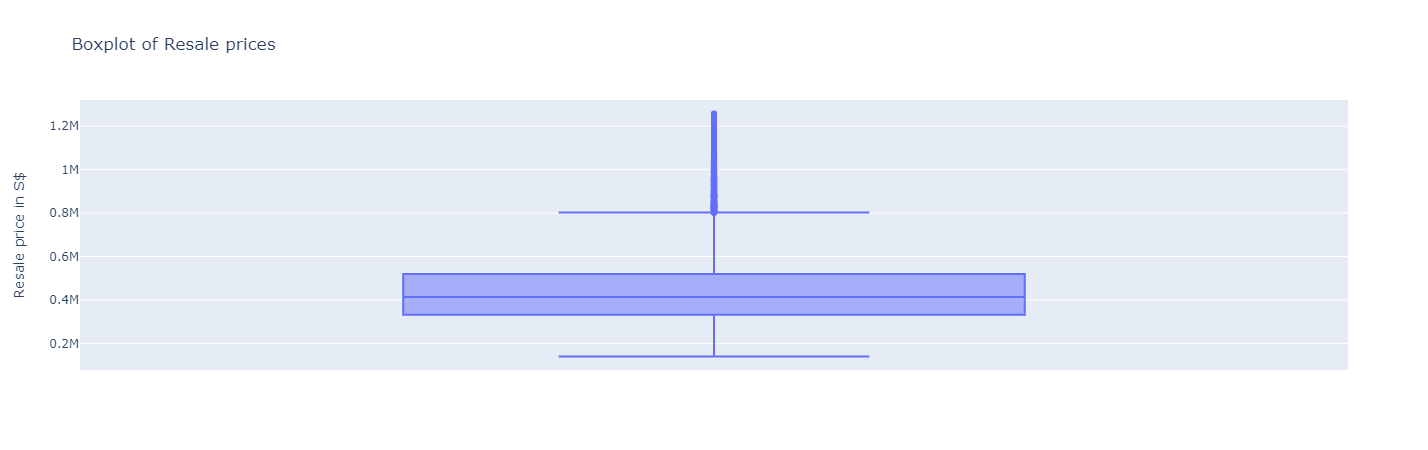

In [16]:
#%% boxplot of resale prices
# entire country

fig = px.box(
        data, 
        y='resale_price', 
        title="Boxplot of Resale prices",
        labels={'resale_price': 'Resale price in S$'})
fig.show()

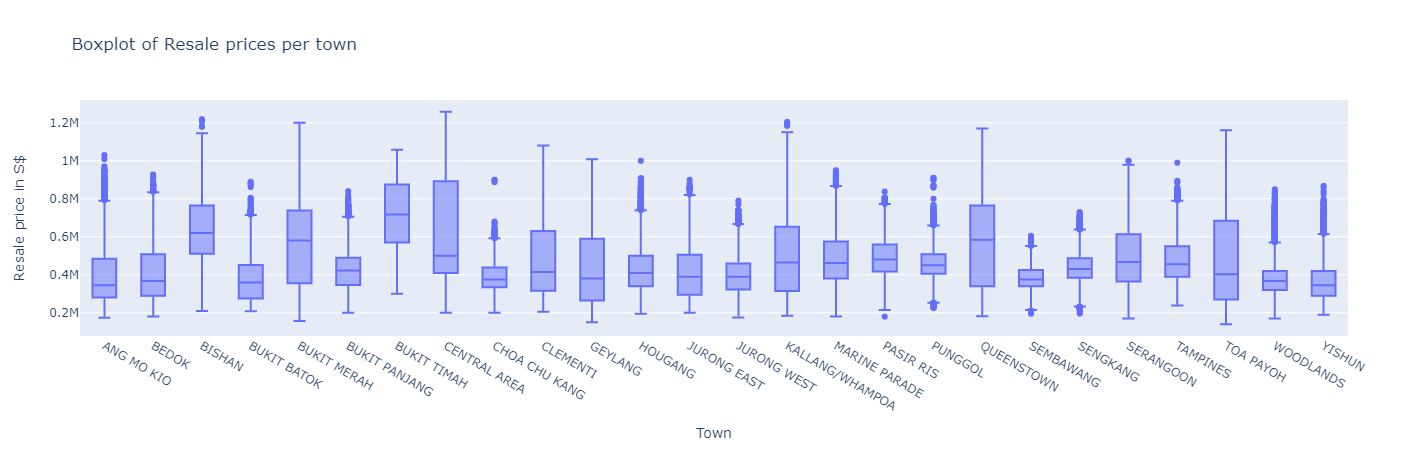

In [17]:
# by town

fig = px.box(
        data, 
        x='town', 
        y='resale_price', 
        title="Boxplot of Resale prices per town",
        labels={'resale_price': 'Resale price in S$',
                'town': 'Town'})
fig.show()

seems like a lot of outliers (since so many outside IQR) but in the news we can see that this is a rising trend (find news articles of expensive HDBs)

# have some overall summary of EDA before proceeding

some thoughts:
- is it true that towns further from city centre are cheaper (seems like it, if we see top 3 cheapest and most exp)
- did covid affect demand (yes, sharp drop then increase to levels even higer than pre covid (maybe due to ppl wanting to move out quicker after CB period?). this sharp increase might have led to increase in price (demand for flats increase, supply remain constant or even drop since workers were in low supply))
- seasonal effects? (yes, at least for 2017, 2018 and 2019. jan always seem to have less transactions)
- punggol and sengkang flats are quite new, maybe thats why they took up a lot of transactions
- pasir ris on avg have significantly larger flats and their prices are not the highest, probably due to its proximity from city centre

debatable to include 2020 data due to covid but its gonna be a new normal moving forward

**maybe should add another binary variable (before covid, after covid)?**

are extreme prices really outlier? they are becoming more common as reported by the news

add in notebook that its more of an art than sci
include links to controversial parts such as standardising of categorical

both gave same results but elasticnetCV is much faster, probably due to warm starts https://github.com/scikit-learn/scikit-learn/issues/11659

another one saying that there is likely no formal way to show what is better, if possible should just try out different combinations
https://datascience.stackexchange.com/questions/37362/when-should-one-use-l1-l2-regularization-instead-of-dropout-layer-given-that-b